# pyGemPick Tutorial 2: Dual High-Contrast Filtering with Detection

## How To Effectively Pick A Lot of Inmmunogold Particles, Fast & Accurate!

{ Insert Video Here Once Completed!}

## Step 1: Micrograph Filtering 

After the images are compressed - the resulting jpg can be compressed and and then detected simpultaneously! __*(Note: I like working with compressed images in a separate folder so they can be reused in subsequent processing steps!)*__ 

I have successfully derived high-contrast versions of common low-pass, edge detecting filters! These show the modifications of the laplace edge detection kernel and laplace of gaussian kernel respectively. Firstly, the kernels were negated and the anchoring value at the center of the kernel was removed and replaced with a scaling factor! Each pass of the filter - produces a binary image where the gold particles are isolated and can be easily detected with optimization of [OpenCv's Simple Blob Detector](https://www.learnopencv.com/blob-detection-using-opencv-python-c/). Note for the HCLAP kernel, anchor values can be chosen 6+ whereas the HLOG kernel anchor values of 18+ are reccommended! These kernels are applied to the image by a matrix convolution operation made possible by [OpenCv's **filter2D( )** function](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/filtering.html)!


### High Contrast Laplace Kernel (HCLAP)


$$\begin{align} \begin{bmatrix}0 &-1 & 0\\-1 & p & -1\\0 & -1 & 0 \end{bmatrix} \end{align}$$


### High Contrast Laplace of Gaussian Kernel (HLOG)


$$\begin{align} \begin{bmatrix}0 & 0 &-1 & 0 & 0\\0 & -1 & -2 & -1 & 0\\-1 & -2 & p & -2 & -1\\0 & -1 & -2 & -1 & 0\\0 & 0 &-1 & 0 & 0 \end{bmatrix} \end{align}$$

## Step 2: Gold Particle Detection 

After sucessful detection, the binary images are then passed into the py.pick() function. This function takes the binary images from one of the filters provided plus 5 additional picking values. __*Note: For best results, it is reccomended that images taken at different magnifications are processed separately in different image sets!*__ 

    1. __minArea:__ allows you to set the minimum number of pixels that will be present in a gold particle on the images which you're trying to detect. 
   
    2. __minCirc:__ allows you to filter the detected gold particles based on how close to a circle that particle looks like. Due to the magnification, excessive counter staining and the properties of the filters themselves - this value will be less than the ideal which is one!
    
$$minCirc = \frac{4*\pi*Area}{(perimeter)^2}$$

    3. __minConv__: As the article above suggests, "Convexity is defined as the (Area of the Blob / Area of it’s convex hull). Convex Hull of a shape is the tightest convex shape that completely encloses the shape.'

![minConv parameter in OpenCv's Simple Blob Detector](https://www.learnopencv.com/wp-content/uploads/2015/02/concave-convex.jpg)

    4. __minIner__: The Inertia ratio of a object allows you to filter the gold particles by how elongated that shape looks.  minIner=1 defines a complete circle. Ideally, this parameter uses a type of Hessian Matrix analysis to gain the required result! Due to the magnification, excessive counter staining and the properties of the filters themselves - this value will be less than the ideal!
    
![minInertia parameter in OpenCv's Simple Blob Detector](https://www.learnopencv.com/wp-content/uploads/2015/02/inertia.jpg)

    5. __minThresh__: applies simple binary thresholding to the image. Usually, when using other filtering techniques and binary image already obtained, this value is set to zero!
    
    

In [17]:
import glob
import cv2
import numpy as np
import pygempick.core as py
import pygempick.modeling as mod
import pygempick.spatialstats as spa
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#input your folder location with compressed jpg images 
images = glob.glob('/home/joseph/Documents/pygempick/samples/compressed/*.jpg') 

In [13]:
#difine filtering paramaters 
pclap = 25 #HCLAP anchor value
plog  = 20 #HLOG anchor value 
i = 0 #image counter

In [5]:
image_number = [] #list for image number counter
detected = [] #list for detected numbr of keypoints

In [14]:
for image in images:
    
    orig_img = cv2.imread(image) ##reads specific jpg image from folder with compressed images
    output1 = py.hclap_filt(pclap, orig_img, 'no')
    output2 = py.hlog_filt(plog, orig_img, 'no')
    #output1 = py.dog_filt(p,orig_img)
    #output2 = py.bin_filt(p, orig_img)
    
    #write each binary images to the binary folder of your choice!
    cv2.imwrite('/home/joseph/Documents/pygempick/samples/binary/{}_hclap_{}.jpg'.format(i, pclap), output1)
    cv2.imwrite('/home/joseph/Documents/pygempick/samples/binary/{}_hlog_{}.jpg'.format(i, plog),output2)
    
    #image, minArea, minCirc, minConv, minIner, minThres
    keypoints1 = py.pick(output1, 37, .71, .5 , .5, 0) 
    keypoints2 = py.pick(output2, 37, .71, .5 , .5, 0)
    
    #this function removes duplicated detections
    keypoints1, dup1 = py.key_filt(keypoints1, keypoints2)
    
    keypoints = keypoints1 + keypoints2
    
    # Draws detected blobs on image with green circles using opencv's draw keypoints 
    imd = cv2.drawKeypoints(orig_img, keypoints, np.array([]), (0,255,0),\
                             cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    #write the image with the picked blobs to the picked folder - change name!
    cv2.imwrite('/home/joseph/Documents/pygempick/samples/picked/{}_picked.jpg'.format(i), imd)
    
    image_number.append(i)
    i+=1
    
    if len(keypoints) > 0:
        detected.append(len(keypoints1))
    else:
        detected.append(0)

In [20]:
print('Total gold particles detected:', sum(detected))

Total gold particles detected: 97


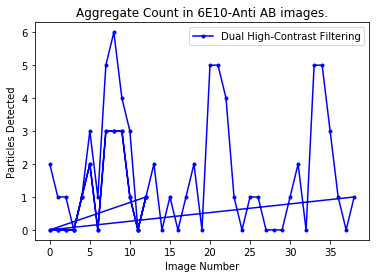

In [18]:
plt.figure()
plt.title('Aggregate Count in 6E10-Anti AB images.')
plt.plot(image_number, np.array(detected) , '.b-', label = "Dual High-Contrast Filtering")
#plt.plot(image_number, detected2, '.r-', label = "Filtered w/ DOG")
plt.xlabel("Image Number")
plt.ylabel("Particles Detected")
plt.legend(loc='best')
plt.show()

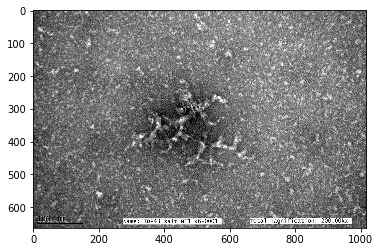

In [21]:
plt.imshow(imd, cmap='gray')


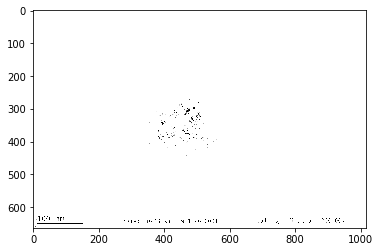

In [22]:
plt.imshow(output1, cmap='gray') #binary image of HCLAP filter


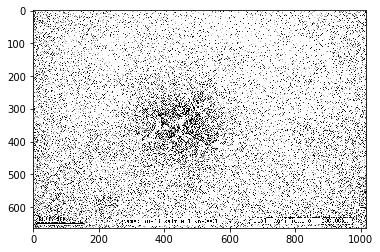

In [23]:
plt.imshow(output2, cmap='gray') #binary image of HLOG filter